In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

In [2]:
# Reading Data
df = pd.read_csv("sales_predictions.csv")

In [3]:
# Fixing inconsistencies in categorical data
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})
df = df.drop_duplicates()

In [4]:
# Features [X] & Target [y]
X = df.drop(['Item_Outlet_Sales'], axis=1)
y = df['Item_Outlet_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Preprocessing Pipeline
num_features = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']
cat_features = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

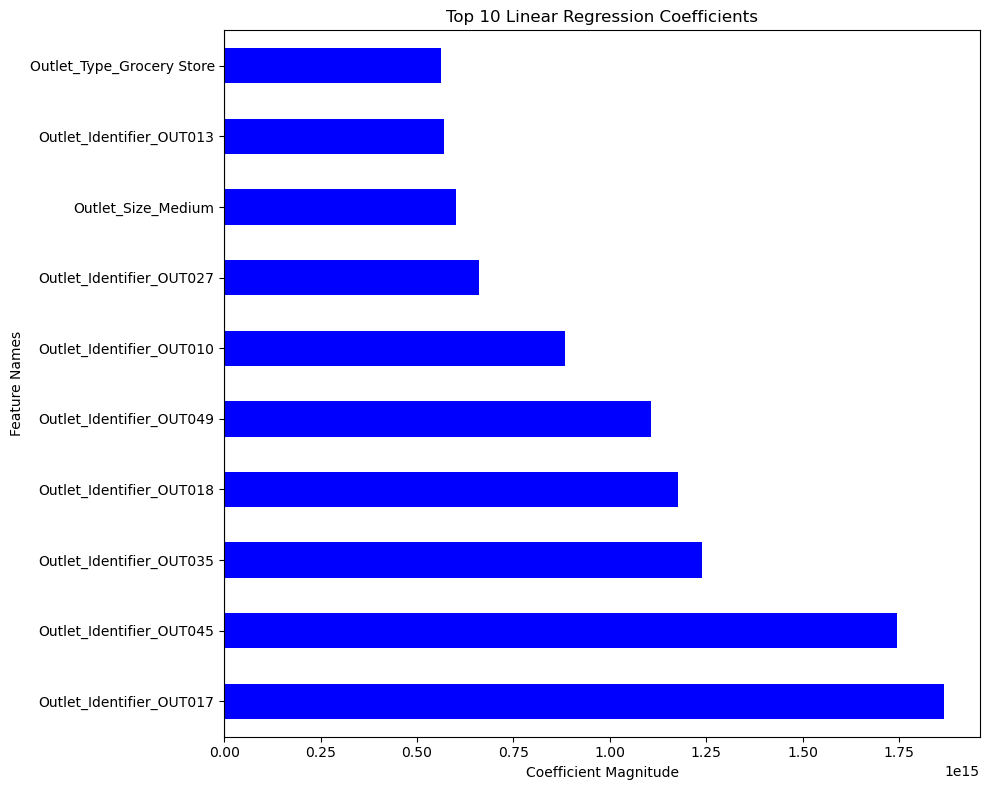

In [6]:
# Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_preprocessed, y_train)

# Extracting and Visualizing Coefficients
coeffs = pd.Series(lin_reg.coef_, index=num_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(input_features=cat_features)))
coeffs_sorted = coeffs.abs().sort_values(ascending=False).head(10)  # Sorting and selecting top 10 coefficients
plt.figure(figsize=(10, 8))
ax = coeffs_sorted.plot(kind='barh', color='blue')
ax.set_xlabel('Coefficient Magnitude')
ax.set_ylabel('Feature Names')
ax.set_title('Top 10 Linear Regression Coefficients')
plt.axvline(0, color='k')
plt.tight_layout()  # Improving spacing between the plot elements
plt.savefig('linear_regression_coefficients.png')

In [7]:
# Top 3 most impactful features for Linear Regression
top_3_linear_regression = coeffs.abs().nlargest(3)
print("Top 3 Most Impactful Features for Linear Regression:")
print(coeffs[top_3_linear_regression.index])

Top 3 Most Impactful Features for Linear Regression:
Outlet_Identifier_OUT017   -1.866990e+15
Outlet_Identifier_OUT045   -1.745791e+15
Outlet_Identifier_OUT035   -1.238255e+15
dtype: float64


In [ ]:
# Tree-Based Model - Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_preprocessed, y_train)

In [ ]:
# Extracting and Visualizing Feature Importances
importances = pd.Series(rf_reg.feature_importances_, index=num_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(input_features=cat_features)))
plt.figure(figsize=(10, 8))
importances.nlargest(10).plot(kind='barh', color='green')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Top 10 Feature Importances for Random Forest Regressor')
plt.savefig('random_forest_feature_importances.png')

In [ ]:
# Top 5 most important features for Random Forest Regressor
top_5_random_forest = importances.nlargest(5)
print("\nTop 5 Most Important Features for Random Forest Regressor:")
print(top_5_random_forest)

# Serialize Your Best Models with Joblib
best_models = {
    "preprocessor": preprocessor,
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "LinearRegression": lin_reg,
    "RandomForestRegressor": rf_reg
}

joblib.dump(best_models, 'best-models.joblib')